#Necessary Downloads


In [1]:
!wget https://www.statmt.org/europarl/v7/ro-en.tgz
!tar -xf ro-en.tgz
!pip install transformers
!pip install SentencePiece
!pip install nltk bert-score

--2023-12-04 05:26:08--  https://www.statmt.org/europarl/v7/ro-en.tgz
Resolving www.statmt.org (www.statmt.org)... 129.215.32.28
Connecting to www.statmt.org (www.statmt.org)|129.215.32.28|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 38180223 (36M) [application/x-gzip]
Saving to: ‘ro-en.tgz’

ro-en.tgz           100%[===================>]  36.41M  11.0MB/s    in 3.3s    

2023-12-04 05:26:13 (11.0 MB/s) - ‘ro-en.tgz’ saved [38180223/38180223]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 21.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.1/61.1 kB 1.8 MB/s eta 0:00:00


#Imports

In [2]:
import numpy as np
import re
import string
import pickle
import pandas as pd
import random
import unicodedata
import torch
import torch.nn as nn
import torchtext
import nltk
import matplotlib.pyplot as plt
import torch.nn.functional as F

In [3]:
from transformers import T5Tokenizer
from transformers import T5ForConditionalGeneration, AdamW
from unicodedata import normalize
from pickle import dump
from __future__ import unicode_literals, print_function, division
from io import open
from torch.utils.data import Dataset, DataLoader, TensorDataset, RandomSampler
from torch import optim
from nltk.translate.bleu_score import sentence_bleu
from nltk.translate.bleu_score import corpus_bleu
from nltk.translate.meteor_score import meteor_score
from bert_score import score as bert_score
from torch.optim import AdamW
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from torchtext.data.metrics import bleu_score

#Device

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Running on {device}')

Running on cuda


#Preprocessing

In [5]:
def readFile(fileName):
    with open(fileName, mode='rt', encoding='utf-8') as file:
        return file.read()

def processSentences(text):
    sentences = text.strip().split('\n')
    regexStatement = re.compile('[^%s]' % re.escape(string.printable))
    translationTable = str.maketrans('', '', string.punctuation)

    filteredSentences = []
    for line in sentences:
        line = normalize('NFD', line).encode('ascii', 'ignore').decode('UTF-8')
        words = [word.lower().translate(translationTable) for word in line.split()]
        words = [regexStatement.sub('', word) for word in words if word.isalpha()]
        filteredSentences.append(' '.join(words))

    return filteredSentences

def saveProcessedSentences(filteredSentences, outputFilename):
    with open(outputFilename, 'wb') as file:
        dump(filteredSentences, file)

def processInputText(fileName, outputFilename):
    text = readFile(fileName)
    filteredSentences = processSentences(text)
    saveProcessedSentences(filteredSentences, outputFilename)
    return filteredSentences

filteredSentences1 = processInputText('europarl-v7.ro-en.en', 'english.pkl')
print("Saved english sentences to english.pkl file")

filteredSentences2 = processInputText('europarl-v7.ro-en.ro', 'romanian.pkl')
print("Saved romanian sentences to romanian.pkl file")

Saved english sentences to english.pkl file
Saved romanian sentences to romanian.pkl file


#Data Loading

In [6]:
with open('romanian.pkl', 'rb') as file:
    romanianData = pickle.load(file)

with open('english.pkl', 'rb') as file:
    englishData = pickle.load(file)

subsetSize = 120000
romanianSubset = romanianData[:subsetSize]
englishSubset = englishData[:subsetSize]

#Model Setup

In [7]:
tokenizer = T5Tokenizer.from_pretrained('t5-small')
tokenizedData = {'input_ids': [], 'attention_mask': [], 'labels': []}
for ro, en in zip(romanianSubset, englishSubset):
    if isinstance(ro, str) and isinstance(en, str):
        tokenizedRomanianData = tokenizer(ro, padding='max_length', truncation=True, max_length=512, return_tensors="pt")
        tokenizedEnglishData = tokenizer(en, padding='max_length', truncation=True, max_length=512, return_tensors="pt")

        tokenizedData['input_ids'].append(tokenizedRomanianData.input_ids)
        tokenizedData['attention_mask'].append(tokenizedRomanianData.attention_mask)
        tokenizedData['labels'].append(tokenizedEnglishData.input_ids)


tokenizer_config.json:   0%|          | 0.00/2.32k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thouroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [8]:
dataTuples = list(zip(tokenizedData['input_ids'], tokenizedData['attention_mask'], tokenizedData['labels']))
trainingTuples, validationTuples = train_test_split(dataTuples, test_size=0.2)

In [9]:
class TranslationDataset(Dataset):
    def __init__(self, dataTuples):
        self.dataTuples = dataTuples

    def __len__(self):
        return len(self.dataTuples)

    def __getitem__(self, index):
        input_ids, attention_mask, labels = self.dataTuples[index]
        return {
            'input_ids': input_ids.squeeze(),
            'attention_mask': attention_mask.squeeze(),
            'labels': labels.squeeze()
        }

In [10]:
trainingDataset = TranslationDataset(trainingTuples)
validationDataset = TranslationDataset(validationTuples)
trainingDataloader = DataLoader(trainingDataset, batch_size=8, shuffle=True)
validationDataloader = DataLoader(validationDataset, batch_size=8)

In [11]:
model = T5ForConditionalGeneration.from_pretrained('t5-small').to(device)
optimizer = AdamW(model.parameters(), lr=5e-5)

config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/242M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

#Training and Validation

In [12]:
def train(model, trainingDataloader, validationDataloader, optimizer, device):
    model.train()
    totalTrainingLoss = 0

    for batch in trainingDataloader:
        optimizer.zero_grad()

        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        totalTrainingLoss += loss.item()

        loss.backward()
        optimizer.step()

    model.eval()
    totalValidationLoss = 0

    with torch.no_grad():
        for batch in validationDataloader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            totalValidationLoss += loss.item()

    return totalTrainingLoss / len(trainingDataloader), totalValidationLoss / len(validationDataloader)

numberOfEpochs = 3
plotTrainingLosses = []
plotValidationLosses = []

for epoch in range(numberOfEpochs):
    plotTrainingLoss, plotValidationLoss = train(model, trainingDataloader, validationDataloader, optimizer, device)
    plotTrainingLosses.append(plotTrainingLoss)
    plotValidationLosses.append(plotValidationLoss)
    print(f"Epoch {epoch+1}/{numberOfEpochs}, Training Loss: {plotTrainingLoss}, Validation Loss : {plotValidationLoss}")

Epoch 1/3, Training Loss: 0.17543360750284046, Validation Loss : 0.09041626262664795
Epoch 2/3, Training Loss: 0.0964717561295256, Validation Loss : 0.07620867740362883
Epoch 3/3, Training Loss: 0.08447862178490807, Validation Loss : 0.07009892344040175


#Plotting Losses

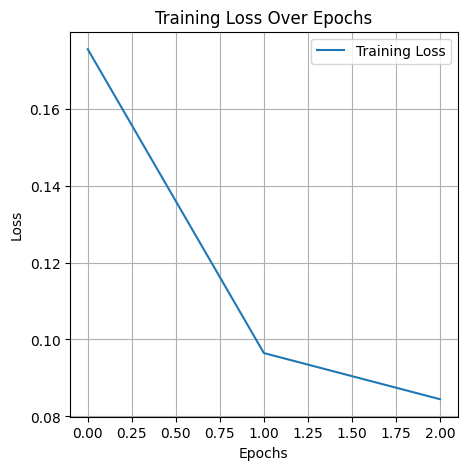

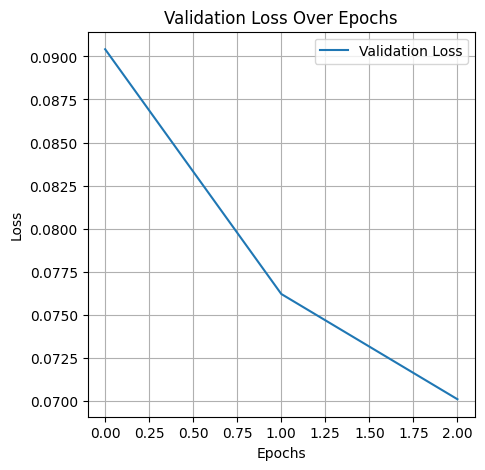

In [13]:
def showTrainingPlot(plotLosses):
    plt.figure(figsize=(5, 5))
    plt.plot(plotLosses, label='Training Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training Loss Over Epochs')
    plt.legend()
    plt.grid(True)
    plt.show()

def showValidationPlot(plotLosses):
    plt.figure(figsize=(5, 5))
    plt.plot(plotLosses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Validation Loss Over Epochs')
    plt.legend()
    plt.grid(True)
    plt.show()

showTrainingPlot(plotTrainingLosses)
showValidationPlot(plotValidationLosses)

#Saving Model

In [14]:
torch.save(model.state_dict(), 'T5-small.pth')
with open('T5-small.pkl', 'wb') as file:
    pickle.dump(model, file)

#Evaluation on Random Sentences

In [15]:
def evaluationOnRandomSamples(model, dataloader, tokenizer, numberOfSamples=5, max_length=50):
    model.eval()
    sampleCount = 0

    for batch in dataloader:
        if sampleCount >= numberOfSamples:
            break

        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        #Ensuring batch dimension is present
        if input_ids.ndim == 1:
            input_ids = input_ids.unsqueeze(0)
        if attention_mask.ndim == 1:
            attention_mask = attention_mask.unsqueeze(0)
        if labels.ndim == 1:
            labels = labels.unsqueeze(0)

        with torch.no_grad():
            outputs = model.generate(input_ids=input_ids, attention_mask=attention_mask, max_length=max_length)

        for i in range(input_ids.size(0)):
            if sampleCount >= numberOfSamples:
                return

            decodedInputSentences = tokenizer.decode(input_ids[i], skip_special_tokens=True)
            decodedPredictedSentences = tokenizer.decode(outputs[i], skip_special_tokens=True)
            decodedExpectedSentences = tokenizer.decode(labels[i], skip_special_tokens=True)

            print(f"Romanian: {decodedInputSentences}\nEnglish (Expected): {decodedExpectedSentences}\nEnglish (Predicted): {decodedPredictedSentences}\n")
            sampleCount += 1

evaluationOnRandomSamples(model, validationDataloader, tokenizer, max_length = 50)

Romanian: de ce nu poate cineva sa castige din orele suplimentare dacasi doreste acest lucru
English (Expected): why should someone not be allowed to earn overtime if that is what they choose to do
English (Predicted): why can anyone not win from the additional orders if they want to do so

Romanian: cred ca a sosit timpul sa spun in acest parlament ca aici unde suveranitatea cetatenilor europeni este la ea acasa noua din zece cetateni reprezentati aici se pronunta in favoarea europei si ca opiniile fundamentale ale partidelor politice importante ale europei sunt si ele in favoarea europei
English (Expected): i believe that the time has come to say in this house that here where the sovereignty of european citizens has its home nine out of ten citizens represented here are in favour of europe and that the underlying beliefs of the major democratic parties of europe are in favour of europe
English (Predicted): i think it was time to say in this house that here where the sovereignty of eu

#Scores Evaluation and Random Testing

In [16]:
nltk.download('wordnet')
def translationMetricsEvaluation(model, dataloader, tokenizer, device):

    model.eval()
    expectedSentencesArray = []
    targetSentencesArray = []

    for batch in dataloader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        with torch.no_grad():
              outputs = model.generate(input_ids=input_ids, attention_mask = attention_mask)

        for i in range(input_ids.size(0)):
            decodedExpected = tokenizer.decode(labels[i], skip_special_tokens=True, truncation=True)
            decodedTarget = tokenizer.decode(outputs[i], skip_special_tokens=True, truncation=True)

            if decodedExpected and decodedTarget:
                expectedSentencesArray.append([decodedExpected.split()])
                targetSentencesArray.append(decodedTarget.split())

    bleuScore = corpus_bleu(expectedSentencesArray, targetSentencesArray)

    meteorScores = [meteor_score(esa, tsa) for esa, tsa in zip(expectedSentencesArray, targetSentencesArray)]
    averageMeteorScores = sum(meteorScores) / len(meteorScores)

    esas = [' '.join(esa[0]) for esa in expectedSentencesArray]
    tsas = [' '.join(tsa) for tsa in targetSentencesArray]
    P, R, F1 = bert_score(tsas, esas, lang="en", verbose=True)

    F1 = F1.mean().item()
    Precision = P.mean().item()
    Recall = R.mean().item()

    return bleuScore, averageMeteorScores, F1, Precision, Recall

bleuScore, meteorScore, F1Score, Precision, Recall = translationMetricsEvaluation(model, validationDataloader, tokenizer, device)

print(f"BLEU Score: {(bleuScore * 100):.4f}")
print(f"METEOR Score: {(meteorScore * 100):.4f}")
print(f"F1 Score: {(F1Score* 100):.4f}")
print(f"Precision: {(Precision* 100):.4f}")
print(f"Recall: {(Recall* 100):.4f}")

[nltk_data] Downloading package wordnet to /root/nltk_data...
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1273: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


config.json:   0%|          | 0.00/482 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/713 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/371 [00:00<?, ?it/s]

done in 181.80 seconds, 130.43 sentences/sec
BLEU Score: 19.7282
METEOR Score: 48.0977
F1 Score: 91.8819
Precision: 93.1660
Recall: 90.6803
